In [0]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [0]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/root/.fastai/data/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [0]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [8]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.636276,1.005495,00:01
1,0.855510,0.668792,00:00
2,0.637899,0.661482,00:00


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [0]:
path=Config.data_path()/'ml-100k'

In [0]:
url= 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'

path_to_zip_file = download_data(url, path/url2name(url),ext='')
directory_to_extract_to = path.parent

import zipfile, os
# zipfile.is_zipfile(path_to_zip_file)
with zipfile.ZipFile(path_to_zip_file , 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

# path.ls()

In [11]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [12]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [13]:
len(ratings)

100000

In [14]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [16]:
data.show_batch()

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


userId,title,target
194,Maverick (1994),3.0
107,Boogie Nights (1997),5.0
11,Real Genius (1985),4.0
746,"River Wild, The (1994)",3.0
749,Gandhi (1982),4.0


In [0]:
y_range = [0,5.5] # to avoid asymptoting at 5

In [0]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1) # weight decay
# n_factors is width of embedding matrix 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


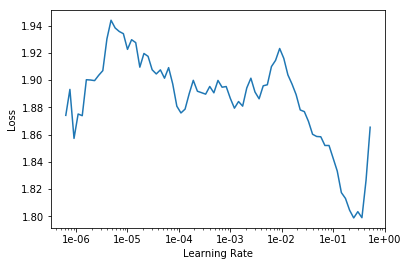

In [19]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [20]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.919811,0.937777,00:13
1,0.836450,0.878740,00:13
2,0.774936,0.842566,00:13
3,0.648422,0.813207,00:13
4,0.564164,0.810601,00:13


In [0]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [0]:
learn.load('dotprod');

In [23]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [24]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [25]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [0]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [0]:
item0 = lambda o:o[0]

In [28]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3496),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3352),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.3046), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2813), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2692), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2493), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2461), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2331), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2270), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2261), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2199), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2188), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2187), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2094), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2069), "McHale's Navy (1997)",

In [29]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5882), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5848), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5787), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5536), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5467), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5358), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5130), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4981), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4910), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4888), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4836), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4741), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4664), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4663), "One Flew Over the Cuckoo's Nest (1975)", 4.291666666666667),
 (tensor(0.4538), 'Godfather, The (1972)', 4.283292978208232)]

### Movie weights

In [30]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [31]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [33]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0969), 'Wrong Trousers, The (1993)'),
 (tensor(1.0965), 'Chinatown (1974)'),
 (tensor(1.0804), 'Lawrence of Arabia (1962)'),
 (tensor(1.0741), 'Close Shave, A (1995)'),
 (tensor(1.0407), 'Casablanca (1942)'),
 (tensor(1.0067), 'Godfather, The (1972)'),
 (tensor(1.0019), 'Persuasion (1995)'),
 (tensor(0.9834), 'Fargo (1996)'),
 (tensor(0.9745), 'When We Were Kings (1996)'),
 (tensor(0.9482), 'Apocalypse Now (1979)')]

In [34]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2622), 'Home Alone 3 (1997)'),
 (tensor(-1.1959), 'Jungle2Jungle (1997)'),
 (tensor(-1.1627), 'Bio-Dome (1996)'),
 (tensor(-1.1576), 'Leave It to Beaver (1997)'),
 (tensor(-1.1266), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.0966), "McHale's Navy (1997)"),
 (tensor(-1.0694), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.0559), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.0392), 'Grease 2 (1982)'),
 (tensor(-1.0387), 'Congo (1995)')]

In [0]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [36]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2096), 'Braveheart (1995)'),
 (tensor(1.1056), 'Raiders of the Lost Ark (1981)'),
 (tensor(1.0849), 'Titanic (1997)'),
 (tensor(0.9040), "It's a Wonderful Life (1946)"),
 (tensor(0.8808), 'Forrest Gump (1994)'),
 (tensor(0.8667), 'Independence Day (ID4) (1996)'),
 (tensor(0.8573), 'Star Wars (1977)'),
 (tensor(0.8369), 'Hunt for Red October, The (1990)'),
 (tensor(0.8054), 'Return of the Jedi (1983)'),
 (tensor(0.8034), 'Top Gun (1986)')]

In [37]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8629), 'Keys to Tulsa (1997)'),
 (tensor(-0.8458), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.8209), 'Stupids, The (1996)'),
 (tensor(-0.8163), 'Trainspotting (1996)'),
 (tensor(-0.7756), 'Jude (1996)'),
 (tensor(-0.7612), 'Very Brady Sequel, A (1996)'),
 (tensor(-0.7539), 'Brazil (1985)'),
 (tensor(-0.7535), 'Cable Guy, The (1996)'),
 (tensor(-0.7400), 'Lost Highway (1997)'),
 (tensor(-0.7350), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)')]

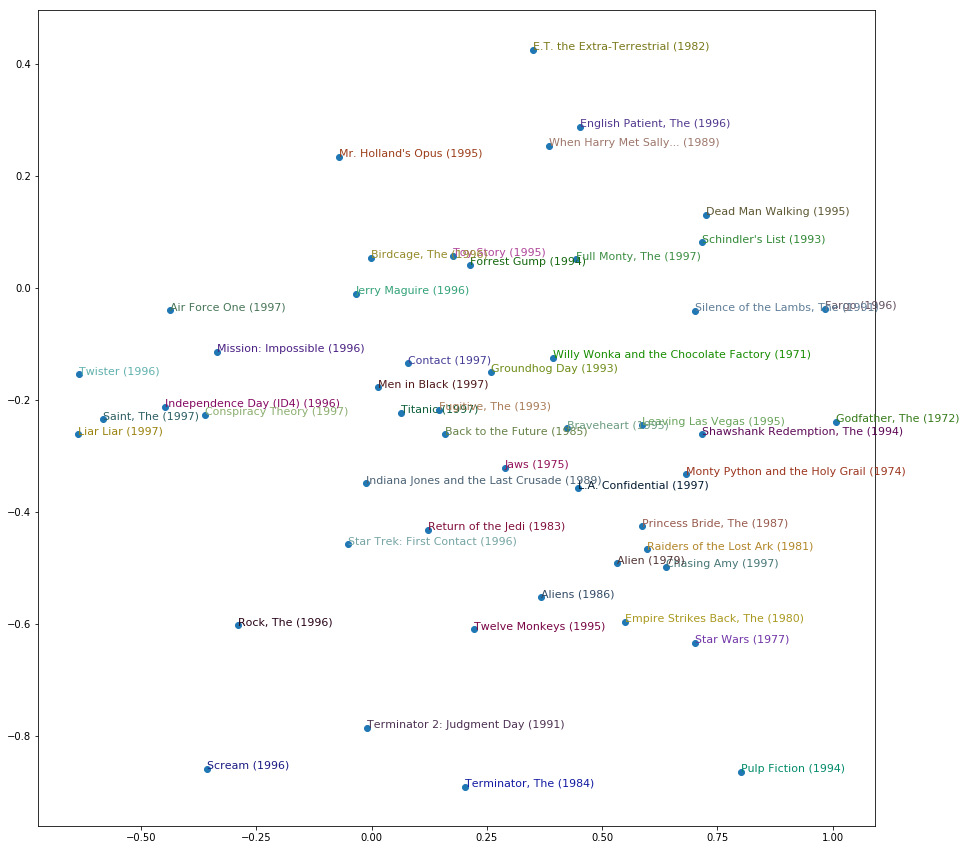

In [38]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()